# Lone Wolf and Cub(s) Stock Prediction

Howdy!

This is the notebook tied to the submission for the [TAMUDatathon 2020](https://tamudatathon.com/) "Stock Prediction" challenge. Further details, including the provenance of the challenge, can be found at the [formal devpost.com submission](https://devpost.com/software/lone-wolf-and-cub-s-stock-prediction-kiz3w5).

For some more context, this was a competition held for undergraduate students, graduate students, and people who gradudated within a year from when the competition was held. As such, I technically participated while being a master's student in Statistics from Texas A&M. 



The crux is that we have daily mystery stock data, a bunch of covariates, and we want to predict next day's return. The twist is that for a consequent buy/sell, we need to place a "fraction" for how much to stake our capital.

# Post Mortem / Caveats

This submission/solution ended up being the winning approach, but there are a litany of reasons why it may not be realistic, including but not limited to liquidity, what's the actual spread, no transaction costs were imposed, etc. Even more so, there's a lot of variance in this whole process that consequently gives you a fighting chance, even with a sub-optimal submission. That being said, imposing and or correcting for all of "that" would potentially have made the challenge less fun for others and just more things to deal with in a 24 hour period. In any case, **I** had fun tooling around and messing with this.

Also, ***to get the most out of this notebook***, you shouldn't really focus too much on the "stock" aspect and instead think of the following as a template for a supervised learning problem and an example of how one constructs pipelines and related items. Really, the way I treated this, was I'm given $X$ and I'm given $y$, now go build a good predictor and everything else was auxiliary.

# Plumbing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import seaborn as sns
import pickle

%matplotlib inline

seed = 42

# Loading and Processing Data

### Getting $X$ and $y$

In [2]:
dat = pd.read_csv("/Users/neuropunk/Documents/_source/_datawrangler/TAMUDatathon2020/stock_trader/mystery_stock_daily_train.csv")

# creating a preliminary target
dat["y1"]   = (dat.open_today.shift(-1) - dat.open_today)/dat.open_today
dat["tgt1"] = dat["y1"]
dat["g1"]   = (dat.tgt1 > 0).astype(np.int)

# saving the target
y = dat["g1"]

# "covariates" we don't want
badCns = ["open", "high", "low", "close", "adj_close", "y1", "tgt1", "g1"]

# NB:
# this is bad, but less painful later, since we select what we want explicitly via indices
# we need this since later, we'll be given a "vector" that we're working with and will have to pick things
X = dat

### Identifying Qualitative and Quantitative Features

In [3]:
# which are indicators?
indSx = []
for cn in X.columns:
    indSx.append([cn, X[cn].value_counts().shape[0]])
indSx = pd.DataFrame(indSx, columns=["sig", "n"]).sort_values("n").reset_index(drop=True)

indFeatures   = list(filter(lambda x: not x in badCns, indSx.query("n < 10 & n > 1").sig.values.tolist()))
indIndices    = list(map(lambda x: x[0], list(filter(lambda x: x[1] in indFeatures, enumerate(X.columns)))))
quantFeatures = list(filter(lambda x: not x in badCns, indSx.query("n >= 10").sig.values.tolist()))
quantIndices  = list(map(lambda x: x[0], list(filter(lambda x: x[1] in quantFeatures, enumerate(X.columns)))))

indSx.query("n < 15")

,sig,n
0,SQZ_NO,1
1,g1,2
2,AOBV_LR_2,2
3,SQZ_ON,2
4,SQZ_OFF,2
5,AOBV_SR_2,2
6,SUPERTd_7_3.0,2
7,AMAT_SR_2,2
8,AMAT_LR_2,2
9,CDL_DOJI_10_0.1,2


### Cleaning up + Splitting

In [4]:
# cleaning up nulls
cleanNdx = X.isnull().sum(axis=1) == 0
X = X.loc[cleanNdx, :]
y = y[cleanNdx]

# learn and test
splitNdx = np.int(X.shape[0]*.66)
xl = X.iloc[:splitNdx, :]
xt = X.iloc[splitNdx:, :]
yl = y[:splitNdx]

# Fitting

Random Forest was initially tried, but due to the low signal to noise ratio, even a single, fully built tree wasn't "low bias high variance" enough for Random Forest to be fully applicable. Instead, Logistic Regression was used in conjunction with $L_1$ and $L_2$ regularization.

### Feature Pipelines

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

class FeatureSelectorIndices(BaseEstimator, TransformerMixin):
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.iloc[:, self.feature_indices]
        elif isinstance(X, np.ndarray):
            return X[:, self.feature_indices]
        else:
            raise ValueError("FeatureSelectorIndices doesn't support: %s" % (type(X)))
    
# quantitative Features
plQuant = Pipeline([
    ("selectQuant", FeatureSelectorIndices(quantIndices)),
    ("stdScaler",   StandardScaler())
])

# quantitative features with arbitrary Transform (not much research; could do yeo-johnson)
def signedSqrt(x):
    return np.sqrt(np.abs(x)) * np.sign(x)

plQuantSignedSqrt = Pipeline([
    ("selectQuant", FeatureSelectorIndices(quantIndices)),
    ("signedSqrt", FunctionTransformer(signedSqrt)),
    ("stdScaler",   StandardScaler())
])

# qualitative features, for which we don't want to standardize
plQual = Pipeline([
    ("selectQual", FeatureSelectorIndices(indIndices))
])

# glomming all the features
plFeatureUnion = FeatureUnion([
    ("quantFeatures", plQuantSignedSqrt),
    ("quantFeatures2", plQuantSignedSqrt),
    ("qualFeatures", plQual)
])

# to later identify which covariates were picked, we construct "features used"
quantFeaturesTxf = ["txf-%s" % x for x in quantFeatures]
featuresUsed = quantFeatures + quantFeaturesTxf + indFeatures

### Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

plLr = Pipeline([
    ("features", plFeatureUnion),
    ("est", LogisticRegression(solver="saga", max_iter=5000, C=10, penalty="elasticnet"))
])

param_grid = {
    'est__C': [0.01, 0.025, 0.05, 0.1, 0.5],
    'est__l1_ratio': [0.75, 0.9, 0.95, 1]

}

gsLr = GridSearchCV(plLr, param_grid, n_jobs=7, scoring="accuracy", cv = 10, refit=True, verbose=3)
gsLr.fit(xl, yl)

gsLrResults = pd.DataFrame(gsLr.cv_results_).loc[:, ["params", "mean_test_score", "std_test_score", "rank_test_score"]].sort_values("rank_test_score").reset_index(drop=True)
gsLrResults

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   16.6s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:   55.0s finished


,params,mean_test_score,std_test_score,rank_test_score
0,"{'est__C': 0.05, 'est__l1_ratio': 0.9}",0.631428,0.090997,1
1,"{'est__C': 0.05, 'est__l1_ratio': 0.95}",0.631428,0.090997,1
2,"{'est__C': 0.05, 'est__l1_ratio': 1}",0.629673,0.091111,3
3,"{'est__C': 0.05, 'est__l1_ratio': 0.75}",0.619328,0.089904,4
4,"{'est__C': 0.025, 'est__l1_ratio': 0.75}",0.619177,0.093746,5
5,"{'est__C': 0.025, 'est__l1_ratio': 1}",0.615850,0.079719,6
6,"{'est__C': 0.025, 'est__l1_ratio': 0.9}",0.612341,0.076613,7
7,"{'est__C': 0.025, 'est__l1_ratio': 0.95}",0.608893,0.074580,8
8,"{'est__C': 0.1, 'est__l1_ratio': 0.95}",0.591652,0.092606,9
9,"{'est__C': 0.1, 'est__l1_ratio': 1}",0.588234,0.095501,10


#### Which Covariates Were Picked? (Out of Curiosity)

In [7]:
estBestLr = gsLr.best_estimator_

coefDf = pd.DataFrame(zip(featuresUsed, estBestLr[-1].coef_.ravel()), columns=["sig", "coef"])
coefDf.query("coef != 0").reset_index(drop=True)

,sig,coef
0,MEDIAN_30,0.048119
1,MACDh_12_26_9,0.040354
2,DPO_20,-0.290463
3,STOCHFk_14,0.001130
4,MAD_30,0.009948
5,KCU_20_2,0.019353
6,Z_30,0.003455
7,COPC_11_14_10,0.024957
8,MASSI_9_25,0.003549
9,txf-MEDIAN_30,0.048119


#### Distribution of Forecasts

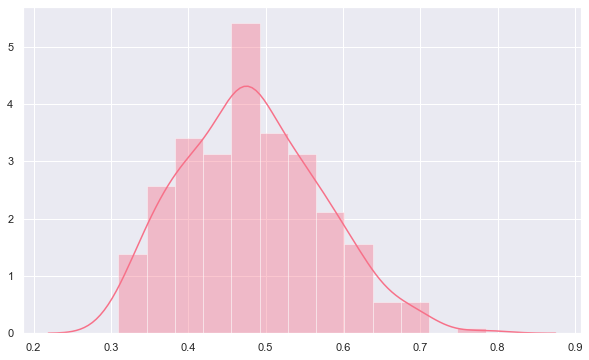

In [8]:
sns.set(palette=sns.color_palette("husl", 2), rc={"figure.figsize": (10,6)})
sns.distplot(estBestLr.predict_proba(xt.values)[:,1])

# Evaluation

### Evaluation Loop

This is what is presumably used on the server side to evaluate your submission, which was provided by the organizers.

In [9]:
import numpy as np
from enum import IntEnum

class Action(IntEnum):
    BUY = 0
    SELL = 1
    HOLD = 2
    
class Evaluation:
    def __init__(self, test_data, starting_cash, agent):
        self.cash = starting_cash
        self.n_shares = 0
        self.test_data = test_data
        self.except_msg = ""

        self.agent = agent

        self.n_buys = 0
        self.n_sells = 0
        self.n_holds = -1 # Always start out with a hold (so need to cancel the default +1). 
        self.account_values = []

        self.evaluate()

    def evaluate(self):
        a = Action.HOLD
        frac = 0        
        for timestep, row in self.test_data.iterrows():            
            # Catch illegal frac value
            if frac > 1:
                raise ValueError(f"You set frac to a value greater than 1 on timestep {timestep} of the test dataset")
            
            if a == Action.BUY:
                self.n_shares += frac*self.cash / row.open_today
                self.cash -= frac * self.cash
                self.n_buys += 1
            elif a == Action.SELL:
                self.cash += frac * self.n_shares * row.open_today
                self.n_shares -= frac * self.n_shares
                self.n_sells += 1
            elif a == Action.HOLD:
                self.n_holds += 1
            else:
                raise ValueError(f"Somehow you returned an illegal action (or not an action at all) on timestep {timestep} of the test dataset. Please fix and try again")

            self.account_values.append(self.total(timestep))

            a, frac = self.agent.step(row.values)

    def total(self, timestep=-1):
        return self.cash + self.n_shares * self.test_data.iloc[timestep].close_prev 

### Agent

Your agent takes in the datum and emits whether it wants to buy, sell, or hold and to what degree.

In [10]:
class AgentLWC:
    def __init__(self, adjK):
        """
        Write your custom initialization sequence here.
        This can include loading models from file.
        """
        self.adjK  = adjK
        
        # NB: this should be loaded from a file for the submission process
        self.model = estBestLr 

    def step(self, row):
        """
        Make a decision to be executed @ the open of the next timestep. 

        row is a numpy array with the same format as the training data

        Return a tuple (Action, fraction). Fraction means different 
        things for different actions...
        
        Action.BUY:  represents fraction of cash to spend on purchase 
        Action.SELL: represents fraction of owned shares to sell 
        Action.HOLD: value ignored.

        See the code below on how to return
        """
        datum = row.reshape([1,-1])
        phat  = self.model.predict_proba(datum)[0,1] * 1.0
        k     = (phat - (1 - phat)) * self.adjK
        k     = min(max(k, 0), 1)

        if phat > 0.5:
            return (Action.BUY, k)
        elif phat <= 0.5:
            return (Action.SELL, k)

        return (Action.HOLD, 0)

### Actual Evaluation

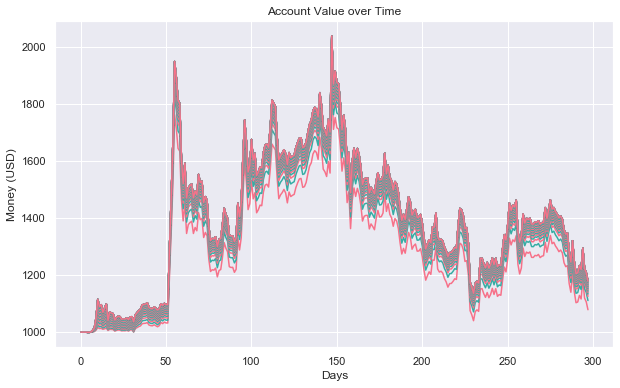

In [11]:
agentStats = []

for adjK in np.arange(0.5, 11, 0.25).tolist() + [5.0]:
    agent = AgentLWC(adjK)
    
    # test data, starting cash, your agent
    e = Evaluation(xt.reset_index(drop=True), 1000, agent)

    agentStats.append([adjK, e.total(), e.cash, e.n_shares, e.n_buys, e.n_sells, e.n_holds])

    plt.plot(e.account_values)
    plt.title("Account Value over Time")
    plt.xlabel("Days")
    plt.ylabel("Money (USD)")
    
agentStats = pd.DataFrame(agentStats, columns=["adjK", "total", "cash", "nShares", "nBuys", "nSells", "nHolds"])
agentStats = agentStats.round(2)

In [12]:
agentStats.sort_values("total", ascending=False).reset_index(drop=True).head()

,adjK,total,cash,nShares,nBuys,nSells,nHolds
0,4.25,1178.54,0.0,527075.43,118,179,0
1,4.50,1178.53,0.0,527070.38,118,179,0
2,4.75,1178.52,0.0,527065.25,118,179,0
3,5.00,1178.51,0.0,527060.03,118,179,0
4,5.00,1178.51,0.0,527060.03,118,179,0


# Submission

Really, the only thing to do here is to refit your model over all the data and then consequently pickle it to disk.

vvvv From the organizer vvvv

Remember: You need to submit a zip file containing
- main.py
- agent.py
- example_model.pt (or the name of your model file)

In [13]:
estBestLr.fit(X, y)

with open("./submission007-lwac-lr-adjust_kc/lwc.mdl", 'wb') as f:
    pickle.dump(estBestLr, f)